### Условие задачи

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Нужно построить модель, которая предскажет температуру стали.


### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).


- `Целевой признак (target)`: последняя измеренная температура.
- `Метрика` : MAE 

### План работы 

1. **Анализ данных.** 
     - Нужно построить граффики, проверить есть ли выбросы. Проверить корреляции финальной температуры с активной мощностью, объемом проволочных материалов, количеством газа.
     

2. **Подготовка данных**
    - Выделить target 
    - Заполнить или удалить пропуски в features. Удалить ненужные данные.


3. **Создание модель** 
    - Разделить данные на тренировочную и тестовую выборки.
    - Протестировать несколько моделей для предсказания и вырать лучшую.
    - Подобрать оптимальные параметры.


4. **Написание выводов**

## 1. Анализ данных

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import math
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV


import warnings
warnings.filterwarnings("ignore")

In [ ]:
data_arc = pd.read_csv('/datasets/final_steel/data_arc.csv', index_col='key')
data_bulk = pd.read_csv('/datasets/final_steel/data_bulk.csv', index_col='key')
data_bulk_time = pd.read_csv('/datasets/final_steel/data_bulk_time.csv', index_col='key')
data_gas = pd.read_csv('/datasets/final_steel/data_gas.csv', index_col='key')
data_temp = pd.read_csv('/datasets/final_steel/data_temp.csv', index_col='key')
data_wire = pd.read_csv('/datasets/final_steel/data_wire.csv', index_col='key')
data_wire_time = pd.read_csv('/datasets/final_steel/data_wire_time.csv', index_col='key')

In [ ]:
data_temp

,Время замера,Температура
key,,
1,2019-05-03 11:16:18,1571.0
1,2019-05-03 11:25:53,1604.0
1,2019-05-03 11:29:11,1618.0
1,2019-05-03 11:30:01,1601.0
1,2019-05-03 11:30:39,1613.0
...,...,...
3241,2019-09-01 04:03:30,1586.0
3241,2019-09-01 04:16:12,NaN
3241,2019-09-01 04:22:39,NaN


In [ ]:
print(data_temp.describe())
print()
print(data_temp.info())
data_temp

        Температура
count  13006.000000
mean    1591.840920
std       21.375851
min     1191.000000
25%     1581.000000
50%     1591.000000
75%     1601.000000
max     1705.000000

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15907 entries, 1 to 3241
Data columns (total 2 columns):
Время замера    15907 non-null object
Температура     13006 non-null float64
dtypes: float64(1), object(1)
memory usage: 372.8+ KB
None


,Время замера,Температура
key,,
1,2019-05-03 11:16:18,1571.0
1,2019-05-03 11:25:53,1604.0
1,2019-05-03 11:29:11,1618.0
1,2019-05-03 11:30:01,1601.0
1,2019-05-03 11:30:39,1613.0
...,...,...
3241,2019-09-01 04:03:30,1586.0
3241,2019-09-01 04:16:12,NaN
3241,2019-09-01 04:22:39,NaN


In [ ]:
data_temp.isna().sum()

Время замера       0
Температура     2901
dtype: int64

In [ ]:
data_temp.query('Температура == "NaN"')

,Время замера,Температура
key,,
2500,2019-08-06 03:24:43,NaN
2500,2019-08-06 03:25:16,NaN
2500,2019-08-06 03:28:21,NaN
2501,2019-08-06 04:01:59,NaN
2501,2019-08-06 04:14:35,NaN
...,...,...
3240,2019-09-01 03:35:16,NaN
3241,2019-09-01 04:16:12,NaN
3241,2019-09-01 04:22:39,NaN


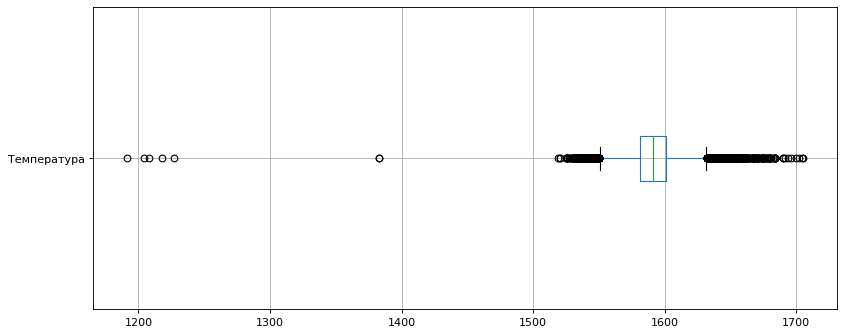

In [ ]:
plt.figure(figsize=(12,5), dpi=80)
data_temp.boxplot(column='Температура', vert=False)
plt.show;

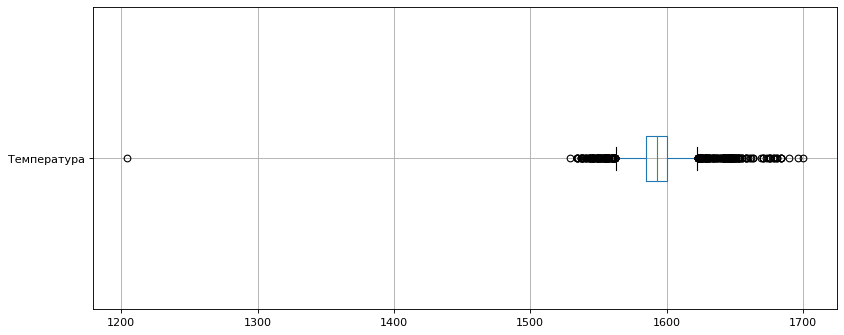

In [ ]:
group_temp = data_temp.groupby('key')['Время замера', 'Температура'].last()
plt.figure(figsize=(12,5), dpi=80)
group_temp.boxplot(column='Температура', vert=False)
plt.show;

In [ ]:
group_arc = data_arc.groupby('key')['Активная мощность', 'Реактивная мощность'].last()

print(group_temp['Температура'].corr(group_arc['Активная мощность']))
print(group_temp['Температура'].corr(group_arc['Реактивная мощность']))

0.13392313115228607
0.10742558977964724


 ##  2. Подготовка данных

In [ ]:
def pivot(data, index, values, columns):
    data = data.fillna(0)
    data = pd.pivot_table(data, index=[index], values=values, aggfunc=['first', 'last'])
    data.columns = columns
    return data

In [ ]:
pivot_data_temp = pivot(data_temp, 'key', 'Температура', ('first_temp', 'last_temp')).query('last_temp != 0.0')
pivot_data_temp

,first_temp,last_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
2495,1570.0,1591.0
2496,1554.0,1591.0
2497,1571.0,1589.0


In [ ]:
#Создадим столбцы полной мощности для первого и последнего замеров

pivot_data_arc = pivot(data_arc, 'key',
                      ('Активная мощность', 'Реактивная мощность'), 
                      ('first_a_power', 'first_r_power', 'last_a_power', 'last_r_power'))
pivot_data_arc
pivot_data_arc['first_full_power'] = pivot_data_arc.apply(lambda x: math.sqrt((x[0])**2 + (x[1])**2), axis=1)
pivot_data_arc['last_full_power'] = pivot_data_arc.apply(lambda x: math.sqrt((x[2])**2 + (x[3])**2), axis=1)

In [ ]:
# Создадим столбцы с суммами добавок

data_bulk['bulk_sum'] = data_bulk.sum(axis=1)
data_wire['wire_sum'] = data_wire.sum(axis=1)
data_gas.columns = ['gas']

In [ ]:
#Создадим колонку время нагрева

data_temp['Время замера'] = pd.to_datetime(data_temp['Время замера'], format='%Y-%m-%d %H:%M:%S')
data_temp['Время замера'] = pd.to_timedelta(data_temp['Время замера'])
time = data_temp.groupby('key').agg({'Время замера': ['first', 'last']})
time.columns = ['начальное время замера', 'финальное время замера']
time['heating_time'] = time['финальное время замера'].dt.total_seconds() - time['начальное время замера'].dt.total_seconds()

In [ ]:
#Объединим все столбцы в одну таблицу по индексу key

full_data = pivot_data_temp.merge(pivot_data_arc, how='left', on='key')
full_data = full_data.merge(data_bulk, how='left', on='key')
full_data = full_data.merge(data_wire, how='left', on='key')
full_data = full_data.merge(data_gas, how='left', on='key')
full_data = full_data.merge(time['heating_time'], how='left', on='key')

#Добавим стобец работа перемножив время нагрева и полную мощность
full_data['work'] = full_data['heating_time'] * full_data['last_full_power']

In [ ]:
full_data.isna().sum()

first_temp             0
last_temp              0
first_a_power          2
first_r_power          2
last_a_power           2
last_r_power           2
first_full_power       2
last_full_power        2
Bulk 1              2278
Bulk 2              2464
Bulk 3              1512
Bulk 4              1663
Bulk 5              2424
Bulk 6              2033
Bulk 7              2463
Bulk 8              2476
Bulk 9              2464
Bulk 10             2334
Bulk 11             2347
Bulk 12              595
Bulk 13             2463
Bulk 14              340
Bulk 15              764
bulk_sum              69
Wire 1               128
Wire 2              1644
Wire 3              2438
Wire 4              2465
Wire 5              2477
Wire 6              2432
Wire 7              2473
Wire 8              2464
Wire 9              2449
wire_sum             104
gas                    2
heating_time           0
work                   2
dtype: int64

In [ ]:
#Удалим строки с пропущеными значениями в столбце с начальной мощностью
full_data = full_data.dropna(subset = ['first_full_power', 'last_full_power','gas', 'wire_sum', 'bulk_sum', 'work'], 
                             inplace=False)

#Заполним оставшиеся пропуски нулями
full_data = full_data.fillna(0)
full_data.isnull().sum()


first_temp          0
last_temp           0
first_a_power       0
first_r_power       0
last_a_power        0
last_r_power        0
first_full_power    0
last_full_power     0
Bulk 1              0
Bulk 2              0
Bulk 3              0
Bulk 4              0
Bulk 5              0
Bulk 6              0
Bulk 7              0
Bulk 8              0
Bulk 9              0
Bulk 10             0
Bulk 11             0
Bulk 12             0
Bulk 13             0
Bulk 14             0
Bulk 15             0
bulk_sum            0
Wire 1              0
Wire 2              0
Wire 3              0
Wire 4              0
Wire 5              0
Wire 6              0
Wire 7              0
Wire 8              0
Wire 9              0
wire_sum            0
gas                 0
heating_time        0
work                0
dtype: int64

### Проверим данные на коллинеарность.

In [ ]:
corr_data = full_data[['first_a_power', 'first_r_power', 'last_a_power', 'last_r_power', 
                        'first_full_power', 'last_full_power', 'work']].corr()

corr_data[corr_data > 0.95]

,first_a_power,first_r_power,last_a_power,last_r_power,first_full_power,last_full_power,work
first_a_power,1.000000,0.97657,NaN,NaN,0.996478,NaN,NaN
first_r_power,0.976570,1.00000,NaN,NaN,0.991140,NaN,NaN
last_a_power,NaN,NaN,1.000000,NaN,NaN,0.992231,NaN
last_r_power,NaN,NaN,NaN,1.000000,NaN,0.980027,NaN
first_full_power,0.996478,0.99114,NaN,NaN,1.000000,NaN,NaN
last_full_power,NaN,NaN,0.992231,0.980027,NaN,1.000000,NaN
work,NaN,NaN,NaN,NaN,NaN,NaN,1.0


**У столбцов first_full_power и last_full_power сильная корреляция с другими столбцами. Что бы не получить проблему коллинеарности признаков, удалим эти столбцы.**

In [ ]:
full_data = full_data.drop(['first_full_power', 'last_full_power'], axis='columns')

## 3. Подбор модели

In [ ]:
# Выделим целевой признак и признаки

features = full_data.drop(['last_temp'], axis='columns')
target = full_data['last_temp']


# Разделим датасет на тренировочную, валидационную и тестовую выборки
train_features, valid_features, train_target, valid_target = train_test_split(features, target, 
                                                                              test_size=0.2, random_state=123)

valid_features, test_features, valid_target, test_target = train_test_split(valid_features, valid_target, 
                                                                            test_size=0.5, random_state=123)


print(train_features.shape, valid_features.shape, test_features.shape, 
      train_target.shape, valid_target.shape, test_target.shape)

(1863, 34) (233, 34) (233, 34) (1863,) (233,) (233,)


In [ ]:
linear_model = LinearRegression()

linear_model.fit(train_features, train_target)
l_predictions = linear_model.predict(valid_features)
mae = mean_absolute_error(l_predictions, valid_target)
mae


7.063561200571469

In [ ]:
%%time

forest_model = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42)
forest_model.fit(train_features, train_target)
f_predictions = forest_model.predict(valid_features)
mae = mean_absolute_error(f_predictions, valid_target)
mae

CPU times: user 14.6 s, sys: 50.2 ms, total: 14.7 s
Wall time: 14.8 s


6.653361936324255

In [ ]:
%%time

cat_boost_model = CatBoostRegressor(iterations=5000, 
                                    max_depth=4, 
                                    learning_rate=0.03, 
                                    loss_function='MAE',
                                    leaf_estimation_method='Exact',
                                    random_state=42)
cat_boost_model.fit(train_features, train_target, verbose=500)
c_predictions = cat_boost_model.predict(valid_features)
mae = mean_absolute_error(c_predictions, valid_target)
mae

0:	learn: 8.0555814	total: 49ms	remaining: 4m 4s
500:	learn: 5.5573950	total: 5.91s	remaining: 53.1s
1000:	learn: 4.9526587	total: 12.1s	remaining: 48.5s
1500:	learn: 4.5963207	total: 18.3s	remaining: 42.6s
2000:	learn: 4.3435765	total: 24.3s	remaining: 36.5s
2500:	learn: 4.1518775	total: 30.4s	remaining: 30.4s
3000:	learn: 4.0103574	total: 36.5s	remaining: 24.3s
3500:	learn: 3.8898003	total: 42.6s	remaining: 18.3s
4000:	learn: 3.7888091	total: 48.7s	remaining: 12.2s
4500:	learn: 3.6933915	total: 54.7s	remaining: 6.07s
4999:	learn: 3.6081929	total: 1m	remaining: 0us
CPU times: user 55.3 s, sys: 6.67 s, total: 1min 1s
Wall time: 1min 4s


6.62872874050076

Лучшие показатели у катбуст. Проверим модель на тестовой выборке.

In [ ]:
test_predictions = cat_boost_model.predict(test_features)
mae = mean_absolute_error(test_predictions, test_target)
mae

6.441537274659712

**Построим граффик важности факторов**

Feature ranking:
Wire 1  -  0.11530767893788592
first_temp  -  0.11295717456968697
heating_time  -  0.08353740477536176
Bulk 6  -  0.07034458649730513
Bulk 15  -  0.06012828304020798
bulk_sum  -  0.05783960700059897
Bulk 14  -  0.05441668012278281
Wire 2  -  0.05430268370823518
Bulk 12  -  0.051446124847876105
gas  -  0.04500789641334598
work  -  0.03887470796690901
Bulk 7  -  0.036058712709545276
last_a_power  -  0.031450647351914655
wire_sum  -  0.030872909319904013
first_r_power  -  0.023245837829494086
first_a_power  -  0.022361648713546938
last_r_power  -  0.02092061356665996
Bulk 1  -  0.01654060037461994
Wire 4  -  0.015329031850843554
Bulk 3  -  0.01468519948440611
Bulk 4  -  0.01256556365053046
Wire 6  -  0.007415659719562729
Bulk 11  -  0.007157582538585175
Wire 7  -  0.004973895839181416
Wire 3  -  0.0036359112072953826
Bulk 2  -  0.0030926988068698904
Bulk 10  -  0.002293685609031017
Bulk 5  -  0.0017459479713132398
Bulk 13  -  0.0008679129888897216
Wire 9  -  0.00033009352

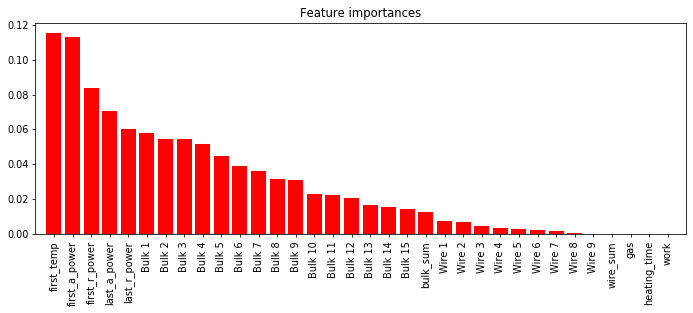

In [ ]:
importances = forest_model.feature_importances_
std = np.std([forest_model.feature_importances_ for tree in forest_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Значения важности факторов.
print("Feature ranking:")

for f in range(train_features.shape[1]):
    print(train_features.columns[indices[f]]," - ", importances[indices[f]])
    

# Построим график.
plt.figure(figsize=(12,4), dpi = 70)
plt.title("Feature importances")
plt.bar(range(train_features.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(train_features.shape[1]), train_features.columns, rotation=90)
plt.xlim([-1, train_features.shape[1]])
plt.show()

# 4. Выводы

Перед началом работы мною были определены 3 этапа. Все этапы были выполнены. Главной трудностью, на мой взгляд, была подготовка признаков из-за небольшого объема данных и многочисленных пропусков в них. Эти проблемы я решил путем удаления пропусков там, где невозможно объяснить их проис хождение и заполнением пропусков на 0 в остальных случаях. Так же я добавил новые признаки, такие как время нагрева, полная мощность, работа,  основанные на исходных данных.

Были выделены следующие ключевые шаги:
- Загрузка данных.
- Предобработка данных: удаление и заполнение пропусков, поиск выбросов в данных.
- Создание новых признаков.
- Объединение данных в единую таблицу и разделение на пизнаки и целевой признак.
- Тестирование нескольких моделей и выбор лучшей.
- Настройка параметров лучшей модели для получения оптимального значения метрики качества.
- Проверка модели на тестовой выборке

Наилучший результат показала модель **CatBoost**. Значение метрики **MAE - 6.44**